<a href="https://colab.research.google.com/github/Sivivatu/trading/blob/master/Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import urllib.parse
import pandas as pd
import matplotlib.pyplot as plt

In [83]:

outputsize = full
getVars = {'function': 'TIME_SERIES_DAILY', 'symbol': 'MSFT', 'apikey': apikey} #https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=MSFT&apikey=demo&datatype=csv}
baseurl = "https://www.alphavantage.co/query?"
url = (baseurl + urllib.parse.urlencode(getVars))

csv_vars = {'function': 'TIME_SERIES_DAILY', 'symbol': 'MSFT', 'apikey': apikey, 'datatype': 'csv', 'outputsize': outputsize}
csv_url = (baseurl + urllib.parse.urlencode(csv_vars))
msft_csv = pd.read_csv(csv_url) #, index_col='timestamp')
msft_csv.sort_values('timestamp', inplace = True)
msft_csv.head()



#:TODO: json option - not owrking write, think later           
#msft_text = pd.read_csv(csv_url) #, skiprows = 2, delimiter = '\0')
#msft = pd.read_json(url)
#msft.drop(msft.index[:2], inplace = True)
#msft.drop(['Meta Data'], axis = 1, inplace = True) 
#msft.head(5)

,timestamp,open,high,low,close,volume
5362,1998-01-02,129.63,131.50,129.50,131.13,4968500
5361,1998-01-05,131.25,133.63,127.87,130.38,10047200
5360,1998-01-06,129.75,133.00,129.25,131.13,8479300
5359,1998-01-07,129.88,131.19,127.50,129.56,7686600
5358,1998-01-08,128.63,132.13,127.50,130.50,9702400


In [84]:
print(msft_csv.shape)
msft_csv.describe()

(5363, 6)


,open,high,low,close,volume
count,5363.000000,5363.000000,5363.000000,5363.000000,5.363000e+03
mean,49.907955,50.514899,49.301465,49.922832,4.723281e+07
std,30.157157,30.598347,29.691329,30.180271,2.874949e+07
min,15.200000,15.620000,14.870000,15.150000,3.458100e+06
25%,27.090000,27.330000,26.920000,27.125000,2.768005e+07
50%,35.660000,35.910000,35.340000,35.590000,4.236470e+07
75%,65.120000,65.815000,64.485000,65.115000,5.969640e+07
max,178.940000,180.380000,175.750000,179.940000,5.910522e+08


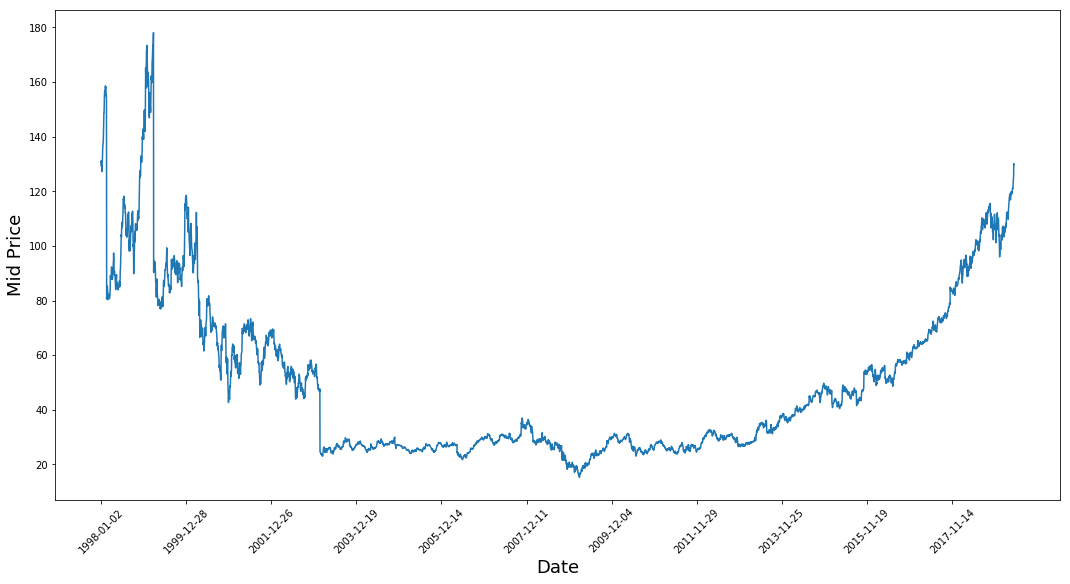

In [88]:
plt.figure(figsize = (18,9))
plt.plot(range(msft_csv.shape[0]),(msft_csv['low']+msft_csv['high'])/2.0)
plt.xticks(range(0,msft_csv.shape[0],500),msft_csv['timestamp'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [0]:
msft_csv['mid'] = (msft_csv['low']+msft_csv['high'])/2.0

In [0]:
SEQ_LEN = 60  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "mid"

In [0]:
def classify(current, future):
    if float(future) > float(current):
        return 1
    else:
        return 0

In [0]:
df['future'] = df[RATIO_TO_PREDICT].shift(-FUTURE_PERIOD_PREDICT)

In [0]:
df['target'] = list(map(classify, df[RATIO_TO_PREDICT], df['future']))